In [1]:
import os
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms
from pytorchcv.model_provider import get_model as ptcv_get_model


# Device configuration
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Custom Dataset

In [2]:

class CustomImageDataset(Dataset):

    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_list = os.listdir(self.img_dir)
        img_path = os.path.join(self.img_dir, img_list[idx])
        image = read_image(img_path).float() / 255
        label = int(img_list[idx].split("_")[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### mean & std

In [3]:
test_dataset = CustomImageDataset("./data/images")

mean = 0
std = 0

for data in test_dataset:
    mean += data[0].mean(axis=(1,2))
    std += data[0].std(axis=(1,2))

print(mean / len(test_dataset), std / len(test_dataset))

tensor([0.5014, 0.4793, 0.4339]) tensor([0.1998, 0.1963, 0.2025])


### Load Dataset and Model

In [7]:
model = ptcv_get_model("resnet1202_cifar100", pretrained=True)
model.to(device)

clean_dataset = CustomImageDataset("./data/images", 
                    transform=transforms.Normalize(mean=[0.5014, 0.4793, 0.4339], 
                                                   std=[0.1998, 0.1963, 0.2025]))
clean_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

attack_dataset = CustomImageDataset("./results")
attack_loader = DataLoader(dataset=attack_dataset, batch_size=100, shuffle=False)

### Evaluation

In [5]:

correct = 0
total = 0

for images, labels in clean_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 100.0 %


In [8]:
correct = 0
total = 0

for images, labels in attack_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 11.6 %


Label: crab, Predicted: turtle


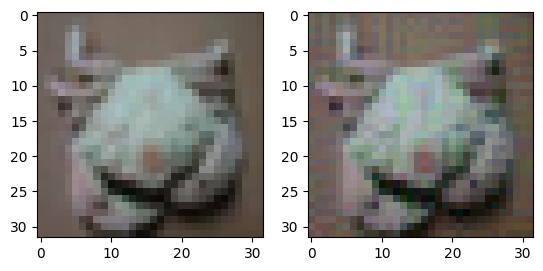

In [15]:
import random
from  mapping import true_labels
import matplotlib.pyplot as plt

n = random.randint(0, 499)

image = attack_dataset[n][0].to(device).reshape((1,3,32,32))
label = attack_dataset[n][1]

output = model(image)
_, predicted = torch.max(output.data, 1)

print(f"Label: {true_labels[label]}, Predicted: {true_labels[predicted[0]]}")

original_image = test_dataset[n][0].numpy().transpose(1,2,0)
perturbed_image = attack_dataset[n][0].numpy().transpose(1,2,0)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(original_image)
axarr[1].imshow(perturbed_image)
plt.show()